# Condensation BulkAnnotations (For visualisation alone: R-Kernel not installed, please use this notebook for viewing alone)


This notebook shows ...
1. what the romero.gateway actually is. 
2. how to access/browse the data on the OMERO server.
3. how to load and work with the meta data which can be attached to OME objects.
4. how to request and plot thumbnails.

It uses the data from [idr0002-heriche-condensation/screenA](http://10.0.51.164/webclient/?show=screen-102) (see also  [Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation](http://www.molbiolcell.org/content/25/16/2522)) which is hosted on an IDR clone running the latest 5.3 version of OMERO.

- Article is about a software for predicting functional relationships of genes.
- The screen is the experimental validation of 100 predicted novel candidate genes involved in mitotic chromosome condensation.
- RNA interference: 2 siRNA per gene with 4 replicates, i.e. 8 samples per gene.
- Screen with 12 96-Well plates, 2 channel timelapse images with 329 time points at 8.5 min, e. g. [CDC20](http://10.0.51.164/webclient/img_detail/250083/).
- Authors measured length of prophase (CellCognition), calculated a 'Short' and a 'Long' prophase score.
- 'Short'/'Long' prophase score > threshold --> 'Short'/'Long' prophase phenotype. More than two Short or Long phenotype replicates --> Gene is involved in mitotic chromosome condensation

The notebook only accesses this data, make some plots, etc. to show how one can interact with OMERO from R. The notebook does not re-analyse the study.


# The romero.gateway package

- The [romero.gateway](https://github.com/ome/rOMERO-gateway) is an R library which builds on top of the [OMERO Java Gateway](http://downloads.openmicroscopy.org/omero/5.3.2/api/omero/gateway/Gateway.html). The current version uses the latest OMERO 5.3.3 Snapshot libraries.
- It makes heavy use of the [rJava](https://www.rforge.net/rJava/) library to 'translate' between Java and R
- Provides various methods to request from and write data to an OMERO server

![Overview](../includes/romero_overview_2.png)

## Load the romero.gateway library

In [1]:
library(romero.gateway)

Loading required package: rJava
Loading required package: jpeg
Warning message:
“replacing previous import ‘rJava::tail’ by ‘utils::tail’ when loading ‘romero.gateway’”Warning message:
“replacing previous import ‘rJava::str’ by ‘utils::str’ when loading ‘romero.gateway’”Warning message:
“replacing previous import ‘rJava::head’ by ‘utils::head’ when loading ‘romero.gateway’”
*** Welcome to rOMERO ***



## Connect to the server

In [2]:
server <- OMEROServer(host = 'IDR_HOST', username = 'IDR_USERNAME', password = 'IDR_PASSWORD', port = as.integer('IDR_PORT'))
ome <- connect(server)

## Example 1: Access/Browse data

### Load screen: idr0002-heriche-condensation/screenA 

In [4]:
searchResult <- searchFor(ome, Screen, 'Name', '"idr0002-heriche-condensation/screenA"')
screen <- searchResult[[1]]
print(screen@dataobject$getName())

[1] "idr0002-heriche-condensation/screenA"


If necessary one can always get direct access to the underlying Java object via '@dataobject'

### 'Browse' through the data
For example load some plates, wells, etc.
(You can do the same with Projects/Datasets hierarchy accordingly)

In [5]:
plates <- getPlates(screen)
plate1 <- plates[[1]]
plate2 <- plates[[2]]

wells <- getWells(plate1)
well <- wells[[1]]

print(plate1@dataobject$getName())
print(plate2@dataobject$getName())
print(paste('Well:', well@dataobject$getColumn(), ',', well@dataobject$getRow()))

[1] "plate3_5_002"
[1] "plate1_1_013"
[1] "Well: 0 , 3"


## Example 2: Working with the meta data

### Get information about the meta data attached to the screen

We are particularily interested in the file id of the 'bulk_annotations' file which is necessary for loading the meta data.

In [6]:
annos <- getAnnotations(ome, 'ScreenData', getOMEROID(screen), nameFilter = 'bulk_annotations')
annotationFileID = as.integer(annos$FileID)
print(annotationFileID)

[1] 14209155


As the 'bulk_annotations' file is an HDF file, we can request its content directly as R dataframe. Keep in mind that it could be a huge table and only request the data you need. The loadDataframe method provides ways to perform a query or only load specific rows/columns of the table.
But first get a summary of its content:

### Get data matching a certain condition

E. g. load data for plate 1:

In [7]:
condition <- paste0('(Plate==',getOMEROID(plate1),')')
df1 <- loadDataframe(screen, annotationFileID, condition = condition)
nrow(df1)

[1] 96

### Load specific columns

Only load the data we're interested in (the `bulk_annotations` table can be huge), in that case Plate, Well, Gene, siRNA, Control, Quality Control, Short Prophase Score, Long Prophase Score, Short Prophase and Long Prophase reproducibility:

In [8]:
# Only load first row, we're just interested in the column headers
tmp <- loadDataframe(screen, annotationFileID, rowFrom = 1, rowTo = 1)

# Specify which columns to load
cols <- which(names(tmp) == "Plate")
cols <- c(cols, which(names(tmp) == "Well"))
cols <- c(cols, which(names(tmp) == "Well Name"))
cols <- c(cols, which(names(tmp) == "Gene Symbol"))
cols <- c(cols, which(names(tmp) == "siRNA Identifier"))
cols <- c(cols, which(names(tmp) == "Control Type"))
cols <- c(cols, which(names(tmp) == "Quality Control"))
cols <- c(cols, which(names(tmp) == "Median Deviation Fraction - Shorter Prophase"))
cols <- c(cols, which(names(tmp) == "Median Deviation Fraction - Longer Prophase"))
cols <- c(cols, which(names(tmp) == "Phenotype Reproducibility - Shorter Prophase"))
cols <- c(cols, which(names(tmp) == "Phenotype Reproducibility - Longer Prophase"))

df3 <- loadDataframe(screen, annotationFileID, columns = cols)

Do some reformatting again and display a subset of rows:

In [75]:
# Replace the long column names with shorter ones
names(df3)[names(df3) == 'Plate'] <- 'plateID'
names(df3)[names(df3) == 'Well'] <- 'wellID'
names(df3)[names(df3) == 'Well Name'] <- 'well'
names(df3)[names(df3) == 'Control Type'] <- 'control'
names(df3)[names(df3) == 'siRNA Identifier'] <- 'siRNA'
names(df3)[names(df3) == 'Gene Symbol'] <- 'gene'
names(df3)[names(df3) == 'Quality Control'] <- 'qc'
names(df3)[names(df3) == 'Median Deviation Fraction - Shorter Prophase'] <- 'devShort'
names(df3)[names(df3) == 'Median Deviation Fraction - Longer Prophase'] <- 'devLong'
names(df3)[names(df3) == 'Phenotype Reproducibility - Shorter Prophase'] <- 'repShort'
names(df3)[names(df3) == 'Phenotype Reproducibility - Longer Prophase'] <- 'repLong'

# Reformat the data, e.g. replace empty data with NA
df3$siRNA[ df3$siRNA == "" ] <- NA
df3$gene[ df3$gene == "" ] <- NA
df3[ df3 == "positive control" ] <- 'positive'
df3[ df3 == "negative control" ] <- 'negativ'
df3$control[ df3$control == "" ] <- 'no'
df3$control[ df3$control == "empty well" ] <- NA
df3[ df3 == "not available" ] <- NA
df3$devShort[ df3$devShort == "" ] <- 0
df3$devLong[ df3$devLong == "" ] <- 0
df3$plateID <- gsub('omero\\.gateway\\.model\\.PlateData \\(id=', "", df3$plateID)
df3$plateID <- gsub('\\)', "", df3$plateID)
df3$wellID <- gsub('omero\\.gateway\\.model\\.WellSampleData \\(id=', "", df3$wellID)
df3$wellID <- gsub('\\)', "", df3$wellID)

# Set the correct data type
df3$control <- as.factor(as.character(df3$control))
df3$siRNA <- as.factor(as.character(df3$siRNA))
df3$gene <- as.factor(as.character(df3$gene))
df3$devShort <- as.numeric(as.character(df3$devShort))
df3$devLong <- as.numeric(as.character(df3$devLong))
df3$repShort <- as.numeric(substr(as.character(df3$repShort), 1, 1))
df3$repLong <- as.numeric(substr(as.character(df3$repLong), 1, 1))
df3$qc <- as.factor(as.character(df3$qc))
df3$well <- as.factor(as.character(df3$well))

df3[1:15,]

plateID,wellID,well,gene,siRNA,control,qc,devShort,devLong,repShort,repLong
422,67070,a1,CDC20,s2748,positive,fail,0.00,0.00,NA,NA
422,67069,a2,AKAP8,s20068,no,pass,0.25,-0.07,2,0
422,67080,a3,GDF9,s5681,no,pass,0.15,-0.03,1,0
422,67114,a4,MYST3,s15534,no,pass,-0.09,0.02,1,0
422,67089,a5,CHMP1A,s10143,no,pass,0.18,-0.01,1,0
422,67079,a6,CDK1,s465,no,pass,-0.25,0.20,0,2
422,67123,a7,MYST3,s15532,no,pass,0.02,0.10,1,2
422,67090,a8,NCAPG,s34513,no,pass,0.00,0.07,0,0
422,67148,a9,NCAPD2,s19235,no,pass,0.16,-0.08,0,0
422,67155,a10,PAPD7,s21758,no,pass,-0.07,0.03,1,1


You can request some basic information about the screen, e. g. how many controls and samples there are
('control == no' means sample), how many samples per gene, etc.:

In [13]:
library(plyr)
count (df3$control)

x,freq
negativ,48
no,808
positive,48
NA,248


In [76]:
rows = 50
display_transpose <- function(df, rows){
transpose = t(df[1:rows, 2:ncol(df)])
colnames(transpose) <- df[1:rows,1]
transpose
}

count_frame = as.data.frame(count (df3$gene))
display_transpose(count_frame, rows)

ACIN1,AIFM1,AIFM2,AKAP8,ASH1L,ATM,AURKA,BRCA2,BRF1,CAPG,⋯,MYST3,NAA10,NCAPD2,NCAPD3,NCAPG,NCAPG2,NCAPH,NCAPH2,NDC80,NEK6
8,8,8,8,8,8,8,8,8,8,⋯,8,8,8,8,8,8,8,8,8,8


Some quality assessment:

Is there a relationship between quality control and well position?

In [77]:
part_table = as.data.frame(table(df3$well, df3$qc))
display_transpose(part_table, rows)

chisq_test = chisq.test(df3$qc, df3$well)
chisq_test_frame

,a1,a10,a11,a12,a2,a3,a4,a5,a6,a7,⋯,d2,d3,d4,d5,d6,d7,d8,d9,e1,e10
Var2,fail,fail,fail,fail,fail,fail,fail,fail,fail,fail,⋯,fail,fail,fail,fail,fail,fail,fail,fail,fail,fail
Freq,12,4,3,3,2,4,3,4,5,3,⋯,5,4,5,8,9,9,11,8,5,6



	Pearson's Chi-squared test

data:  df3$qc and df3$well
X-squared = 175.66, df = 95, p-value = 9.483e-07


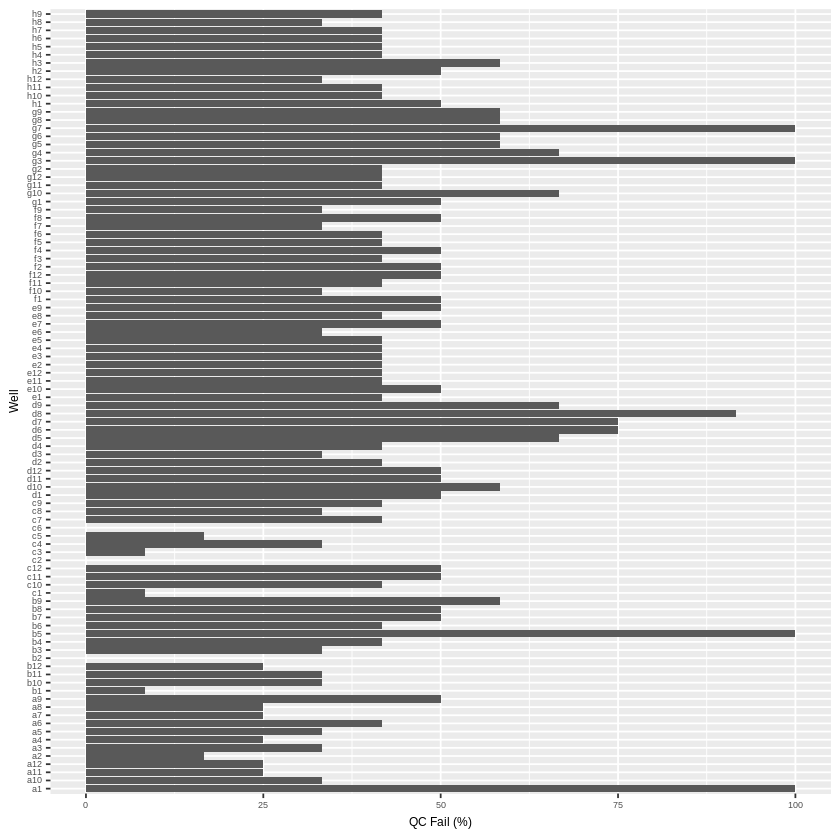

In [78]:
library(ggplot2)
fails <- as.data.frame(table(df3$well, df3$qc))
fails <- subset(fails, fails$Var2 == 'fail')
fails$Freq <- fails$Freq / 12 * 100
p <- ggplot(fails, aes(x = fails$Var1, y = fails$Freq))
p <- p + geom_bar(stat="identity")
p <- p + labs(y = "QC Fail (%)")
p <- p + labs(x = "Well")
p <- p + theme(text = element_text(size=7))
p <- p + coord_flip()
p

Is there a relationship between quality control and gene?

In [79]:
control_gene_df = as.data.frame(table(df3$gene, df3$qc))
display_transpose(control_gene_df, rows)

,ACIN1,AIFM1,AIFM2,AKAP8,ASH1L,ATM,AURKA,BRCA2,BRF1,CAPG,⋯,MYST3,NAA10,NCAPD2,NCAPD3,NCAPG,NCAPG2,NCAPH,NCAPH2,NDC80,NEK6
Var2,fail,fail,fail,fail,fail,fail,fail,fail,fail,fail,⋯,fail,fail,fail,fail,fail,fail,fail,fail,fail,fail
Freq,2,2,2,1,0,3,4,0,0,5,⋯,2,2,3,4,3,3,2,3,1,1


Warning message:
“Removed 2 rows containing missing values (position_stack).”

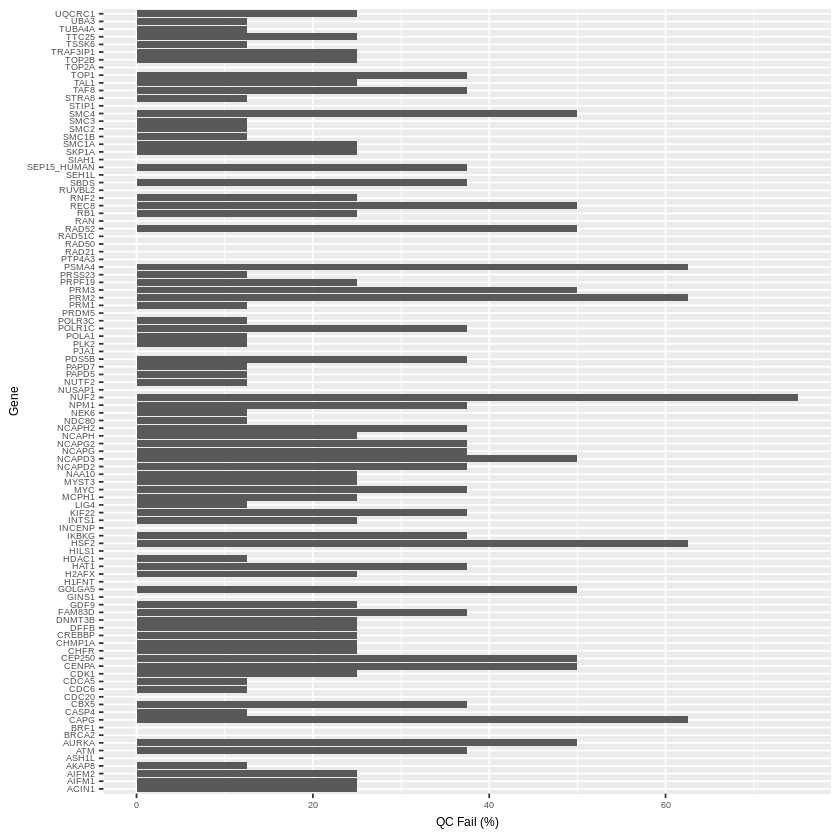

In [80]:
fails <- as.data.frame(table(df3$gene, df3$qc))
fails <- subset(fails, fails$Var2 == 'fail')
fails$Freq[fails$Var1 == 'INCENP']  <- NA
fails$Freq[fails$Var1 == 'CDC20']  <- NA
fails$Freq <- fails$Freq / 8 * 100
p <- ggplot(fails, aes(x = fails$Var1, y = fails$Freq))
p <- p + geom_bar(stat="identity")
p <- p + labs(y = "QC Fail (%)")
p <- p + labs(x = "Gene")
p <- p + theme(text = element_text(size=7))
p <- p + coord_flip()
p

### Replicate some of the articles figures

The authors postulate, that a gene is considered as being involved in mitotic chromosome condensation, when either its
short or its long prophase phenotype showed up in at least two replicates.
Extract the 'short' and the 'long' phenotype genes:

In [81]:
dfLongProphase <- subset(df3, df3$repLong > 1)
longProphaseGenes <-  as.list(as.character(count(dfLongProphase$gene)$x))
print('Hits with long prophase:')
paste(longProphaseGenes)

dfShortProphase <- subset(df3, df3$repShort > 1)
shortProphaseGenes <-  as.list(as.character(count(dfShortProphase$gene)$x))
print('Hits with short prophase:')
paste(shortProphaseGenes)

[1] "Hits with long prophase:"


[1] "CDK1"        "DNMT3B"      "GINS1"       "H1FNT"       "INTS1"      
 [6] "MCPH1"       "MYST3"       "NAA10"       "NEK6"        "PAPD5"      
[11] "POLR3C"      "PTP4A3"      "RUVBL2"      "SEP15_HUMAN" "SIAH1"      
[16] "SMC1A"       "TOP2A"

[1] "Hits with short prophase:"


[1] "AKAP8"       "BRF1"        "CBX5"        "CDCA5"       "CHFR"       
 [6] "HDAC1"       "HILS1"       "INTS1"       "KIF22"       "NAA10"      
[11] "NCAPD3"      "NCAPG2"      "NCAPH2"      "NUTF2"       "PJA1"       
[16] "RAN"         "SEP15_HUMAN" "SMC2"        "SMC4"        "TAL1"       
[21] "TOP1"        "TRAF3IP1"

Why is SEP15_HUMAN in both lists but it is not in the artice (Table 2)?

In [82]:
sep15 <- subset(df3, df3$gene == 'SEP15_HUMAN')
sep15
summary(sep15)

,plateID,wellID,well,gene,siRNA,control,qc,devShort,devLong,repShort,repLong
93,422,67149,h9,SEP15_HUMAN,s17997,no,pass,-0.04,0.10,0,2
189,492,93720,h9,SEP15_HUMAN,s17997,no,fail,-0.04,0.10,0,2
285,559,119104,h9,SEP15_HUMAN,s17997,no,pass,-0.04,0.10,0,2
381,620,142155,h9,SEP15_HUMAN,s17997,no,pass,-0.04,0.10,0,2
426,680,164850,d6,SEP15_HUMAN,s17998,no,pass,0.32,-0.03,2,0
522,728,182874,d6,SEP15_HUMAN,s17998,no,pass,0.32,-0.03,2,0
618,800,209819,d6,SEP15_HUMAN,s17998,no,fail,0.32,-0.03,2,0
714,869,235415,d6,SEP15_HUMAN,s17998,no,fail,0.32,-0.03,2,0


   plateID             wellID               well            gene       siRNA  
 Length:8           Length:8           d6     :4   SEP15_HUMAN:8   s17997 :4  
 Class :character   Class :character   h9     :4   ACIN1      :0   s17998 :4  
 Mode  :character   Mode  :character   a1     :0   AIFM1      :0   s10142 :0  
                                       a10    :0   AIFM2      :0   s10143 :0  
                                       a11    :0   AKAP8      :0   s106   :0  
                                       a12    :0   ASH1L      :0   s107   :0  
                                       (Other):0   (Other)    :0   (Other):0  
     control     qc       devShort        devLong          repShort    repLong 
 negativ :0   fail:3   Min.   :-0.04   Min.   :-0.030   Min.   :0   Min.   :0  
 no      :8   pass:5   1st Qu.:-0.04   1st Qu.:-0.030   1st Qu.:0   1st Qu.:0  
 positive:0            Median : 0.14   Median : 0.035   Median :1   Median :1  
                       Mean   : 0.14   Mean   : 

--> It's just been forgotten to add to the table in the article. See also [MitoSys database](http://www.mitosys.org/cgi-bin/mtc?query=SEP15_HUMAN&query_type=genes)

Replicate the Figures 3B and 3C of the paper:

NCAPD3,NCAPH2,NCAPG2,SMC4,SMC2,RAN,BRF1,CDCA5,CBX5,TRAF3IP1,HDAC1,TAL1,CHFR,SEP15_HUMAN,PJA1,NAA10,TOP1,INTS1,AKAP8,KIF22
0.515,0.5,0.455,0.44,0.41,0.34,0.32,0.295,0.27,0.225,0.195,0.17,0.15,0.14,0.125,0.11,0.11,0.08,0.045,0.045


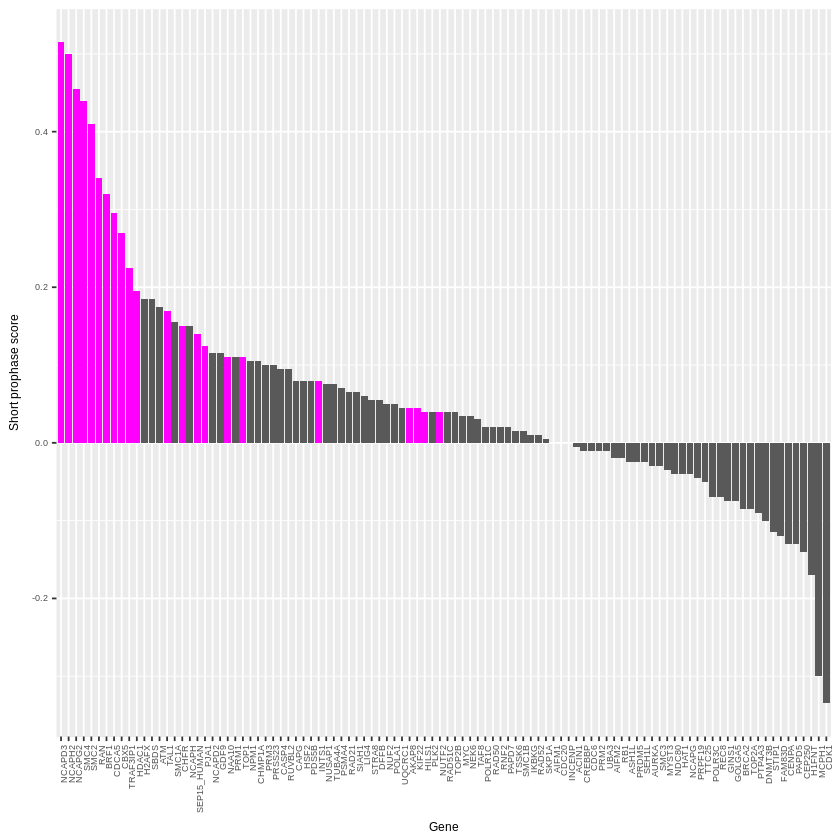

In [84]:
# Only want to plot the mean of the short prophase scores,
# remove NAs and aggregate dataset
data <- subset(df3, !is.na(df3$devShort))
scores <- aggregate(data$devShort, list(gene = factor(data$gene)), FUN='mean')

# Sort the scores dataframe with respect to the score
scores <- scores[order(-scores$x),]
scores$gene <- factor(scores$gene, levels = scores$gene[order(-scores$x)])

# Extract the verified short prohase genes (for marking them in the plot)
scoresShort <- subset(scores, scores$gene %in% shortProphaseGenes)

p <- ggplot(scores, aes(x = scores$gene, y = scores$x))
p <- p + geom_bar(stat="identity") 
p <- p + geom_bar(stat="identity", data = scoresShort, aes(x = scoresShort$gene, y = scoresShort$x), fill = "magenta")
p <-p  + theme(axis.text.x = element_text(angle = 90, hjust = 1))
p <- p + labs(y = "Short prophase score")
p <- p + labs(x = "Gene")
p <- p + theme(text = element_text(size=7))
p

display_transpose(scoresShort, 20)

The second plot for the 'long prophase' genes:

MCPH1,CDK1,DNMT3B,PAPD5,H1FNT,GINS1,POLR3C,PTP4A3,RUVBL2,TOP2A,MYST3,NEK6,INTS1,SEP15_HUMAN,NAA10,SIAH1,SMC1A
0.485,0.205,0.13,0.115,0.075,0.07,0.07,0.07,0.07,0.065,0.06,0.055,0.045,0.035,0.02,0.02,0


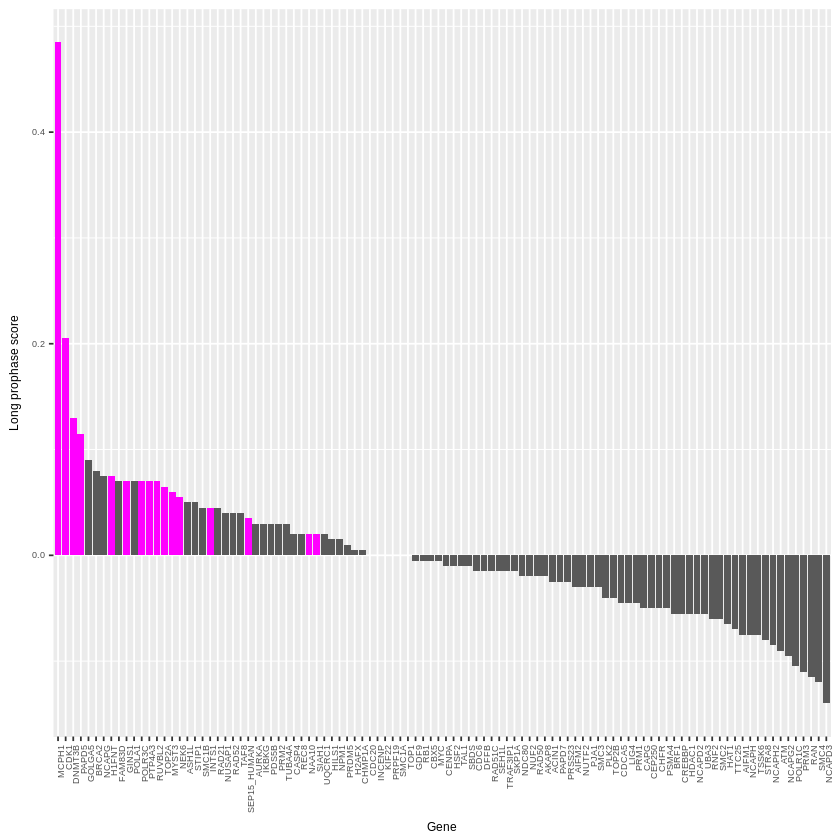

In [87]:
# Only want to plot the mean of the long prophase scores,
# remove NAs and aggregate dataset
data <- subset(df3, !is.na(df3$devLong))
scores <- aggregate(data$devLong, list(gene = factor(data$gene)), FUN='mean')

# Sort the scores dataframe with respect to the score
scores <- scores[order(-scores$x),]
scores$gene <- factor(scores$gene, levels = scores$gene[order(-scores$x)])

# Extract the verified long prohase genes (for marking them in the plot)
scoresLong <- subset(scores, scores$gene %in% longProphaseGenes)

p <- ggplot(scores, aes(x = scores$gene, y = scores$x))
p <- p + geom_bar(stat="identity") 
p <- p + geom_bar(stat="identity", data = scoresLong, aes(x = scoresLong$gene, y = scoresLong$x), fill = "magenta")
p <-p  + theme(axis.text.x = element_text(angle = 90, hjust = 1))
p <- p + labs(y = "Long prophase score")
p <- p + labs(x = "Gene")
p <- p + theme(text = element_text(size=7))
p

display_transpose(scoresLong, 17)

## Example 3: Plotting thumbnails

##### Plot the thumbnails of all images where gene 'SEP15_HUMAN' has been silenced.

First define a function for requesting and plotting a single thumbnail:

In [88]:
plotThumb <- function(df) {
  wellid <- df[[2]]
  well <- loadObject(ome, "WellData", wellid)
  image <- getImages(well, fieldIndex = 0)
  thumb <- getThumbnail(image)
  
  omewell <- well@dataobject
  omeplate <- omewell$getPlate()
  label <- paste0(omeplate$getName(), ' [', omewell$getColumn(), ',',omewell$getRow(), ']')
  
  plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
  title(label)
  rasterImage(thumb,0,0,1,1)
}

Then iterate over the 'SEP15_HUMAN' dataframe and plot the thumbnails:

NULL

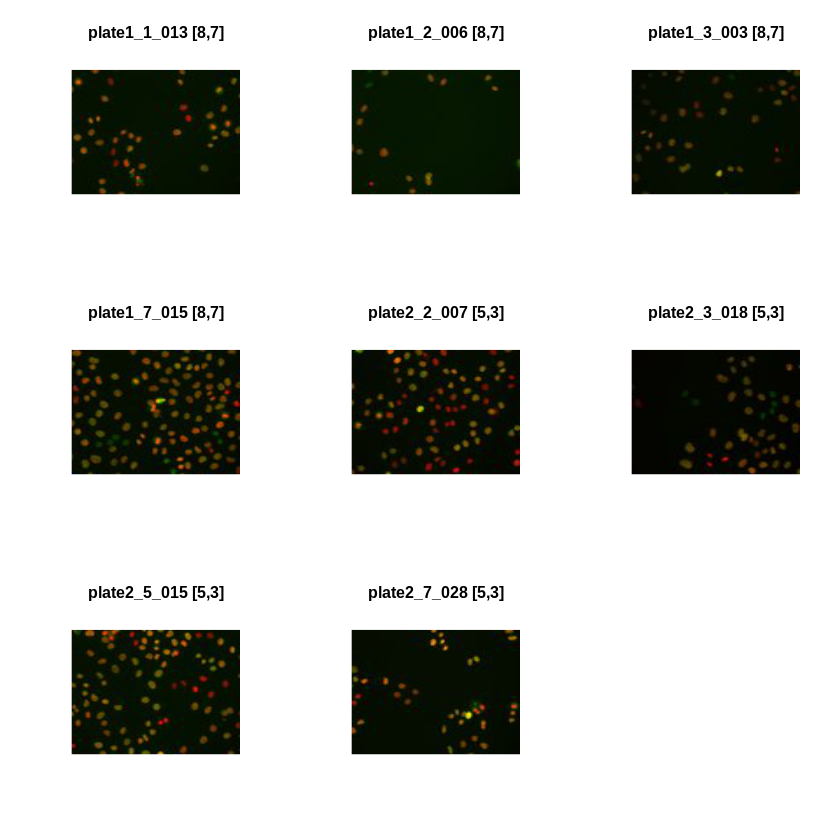

In [89]:
par(mfrow=c(3,3))
apply(sep15, 1, plotThumb)

## Disconnect again from the OMERO server

In [90]:
ome <- disconnect(ome)